In [14]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 

# Task6： 3D Variational methodの実装

## Model

In [15]:
def Lorenz(X, F=8.):
    dXdt = np.array([])
    for i in xrange(len(X)):
        # assume Periodic boundary condition
        diff = (-X[i-2]*X[i-1]+X[i-1]*X[(i+1)%len(X)]-X[i]+F)
        dXdt = np.append(dXdt, diff)
    dXdt = dXdt.reshape((len(dXdt),1))
    return dXdt

In [16]:
def time_step(X,dt, model=None):
    k1 = dt*Lorenz(X, F)
    k2 = dt*Lorenz(X+k1/2, F)
    k3 = dt*Lorenz(X+k2/2, F)
    k4 = dt*Lorenz(X+k3, F)
    return X + (k1/6 + k2/3 + k3/3 + k4/6)

## Kalman filter

### Prediction
$$
\begin{equation}
\\[0pt] \hspace{0mm} x_{t}^f =  f(x_{t-1}^a) 
\end{equation}
$$
\
$$
\begin{equation}
\\[30pt] \hspace{17mm} P_{t}^f= M P_{t-1}^a M^T + C
\end{equation}
$$

#### Mの求め方

$$
\begin{equation}
\\[0pt] \hspace{0mm} f(x_{t}^a + \epsilon) =  f(x_{t}^a ) + M\epsilon+O(\epsilon^2)
\end{equation}
$$
\\
$$
\begin{equation}
\\[0pt] \hspace{5mm} M\epsilon \simeq f(x_{t}^a + \epsilon) - f(x_{t}^a )
\\[10pt] \hspace{9mm} \epsilon_{i} =  (0, 0  \cdots, \delta, \cdots,0)^T とすると
\end{equation}
$$
\\
$$
\begin{equation}
\\[0pt] \hspace{-5mm} M \epsilon_{i} = \delta  \sum_{j}  M_{ji}　より 
\end{equation}
$$
\\
$$
\begin{equation}
\\[0pt] \hspace{10mm} \sum_{j}  M_{ji} =\frac{f(x_{t}^a + \epsilon_{i}) - f(x_{t}^a )}{\delta}　よって
\end{equation}
$$
\\
$$
\begin{equation}
\\[0pt] \hspace{0mm} M =\sum_{j i}  M_{ji} =\sum_{i}\frac{f(x_{t}^a + \epsilon_{i}) - f(x_{t}^a )}{\delta}　
\end{equation}
$$
\\
$$
\begin{equation}
\\[0pt] \hspace{0mm} ただし，　\delta = 10^{-2}　
\end{equation}
$$

In [17]:
def predict(Xa, Pa, C=0., step=1, dt=0.05, model= None, delta=1e-5):
    #prediction of state
    Xf = time_step(Xa, dt=dt, model=model)
    
    #prediction of error
    Pf = Pa
    
    return Xf, Pf

### Analysis
$$
\begin{equation}
\\[0pt] \hspace{0mm} x_{t}^a =  x_{t}^f + K(y^o - H(x_{i}^f))
\end{equation}
$$
\\
$$
\begin{equation}
\\[0pt] \hspace{0mm} P_{t}^a =  (I-K_{i}H)P_{t}^f 
\end{equation}
$$
\\
$$
\begin{equation}
\\[0pt] \hspace{0mm} K_{t} =  P_{i}^f H^T(HP_{i}^fH^T + R)^{-1} 
\end{equation}
$$
\\
$$
\begin{equation}
\\[0pt] \hspace{-50mm} ただし，ここでは
\\[10pt] \hspace{-10mm}H = \bf{I}\in{R^{d\times d}}
\\[10pt] \hspace{-10mm}R = \bf{I}\in{R^{d\times d}}
\\[0pt] \hspace{0mm}
\end{equation}
$$

In [31]:
def fit(obs, Xf, Pf, H, R):
    hoge = np.linalg.inv(np.dot(H, np.dot(Pf,H.T))+R)
    K = np.dot(Pf, np.dot(H.T, hoge))
    Xa = Xf + np.dot(K, obs -np.dot(H, Xf))
    Pa = Pf
    
    return Xa, Pa

In [32]:
def RMSE(obs, X, H):
    x = obs-np.dot(H,X)
    return np.sqrt(np.mean(np.power(x,2)))

In [33]:
def KL_logging(data, true, X0, P0, C, H, R ,dt, model=None):
    #Logging
    records={}
    records["Xf"]=np.array([])
    records["Xa"]=np.array([])
    records["Pf"]=np.array([])
    records["Pa"]=np.array([])
    records["E_pred"]=np.array([])
    records["E_fit"]=np.array([])
    
    Xa = X0
    Pa = P0
    
    # assimilation
    for t in xrange(data.shape[1]):
        #print t
        obs = data[:,t,np.newaxis]
        Xf, Pf= predict(Xa, Pa, C)
        Xa, Pa = fit(obs, Xf, Pf, H, R)
        
        hoge = true[:,t,np.newaxis]
        E_pred = RMSE(hoge, Xf, H)
        E_fit = RMSE(hoge, Xa, H)
    
        records["Xf"]=np.append(records["Xf"], Xf)
        records["Xa"]=np.append(records["Xa"], Xa)
        records["Pf"]=np.append(records["Pf"], Pf)
        records["Pa"]=np.append(records["Pa"], Pa)
        records["E_pred"]=np.append(records["E_pred"], E_pred)
        records["E_fit"]=np.append(records["E_fit"], E_fit)
    
    records["Xf"]=records["Xf"].reshape((data.shape[1],data.shape[0])).T
    records["Xa"]=records["Xa"].reshape((data.shape[1],data.shape[0])).T
    records["Pf"]=records["Pf"].reshape((data.shape[1],data.shape[0],data.shape[0]))
    records["Pa"]=records["Pa"].reshape((data.shape[1],data.shape[0],data.shape[0]))    
    
    return records

## 実行

In [34]:
#Load observed data
a=1400
data = np.load('data_obs.npy')
true=np.load("data_sampled.npy")
data = data[:, :a]
true = true[:,:a]

#Define Initial state & params
dt = 0.05
F = 8.

X0 = np.zeros((len(data),1))
P0 = np.identity(len(data))
C = np.zeros((len(data), len(data)))
H = np.identity(len(data))
R =  np.identity(len(data))

In [35]:
# Assimilation
records = KL_logging(data, true, X0, P0, C, H, R ,dt, model=None)

## 学習結果

### Error (mean(||x-true||^2))^(1/2)をlogプロット

#### RMSEの推移．

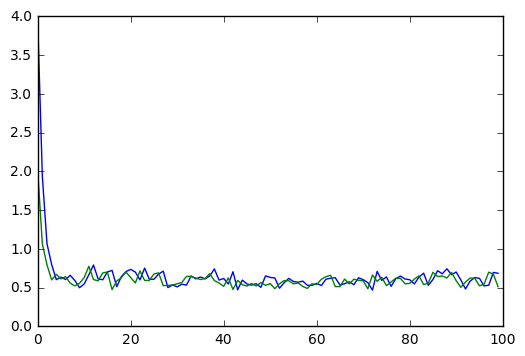

In [37]:
i=0
s=0
g=100
plt.plot(records["E_pred"][s:g])
plt.plot(records["E_fit"][s:g])

In [27]:
np.min(records["E_fit"])

0.38238056573240198

### XfとXaをlogプロット

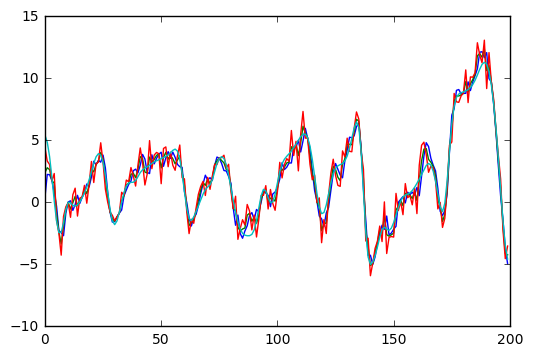

In [38]:
i=1
s=0
g=200
plt.plot(records["Xf"][i, s:g])
plt.plot(records["Xa"][i, s:g])
plt.plot(data[i, s:g])
true=np.load("data_sampled.npy")
plt.plot(true[i, s:g])

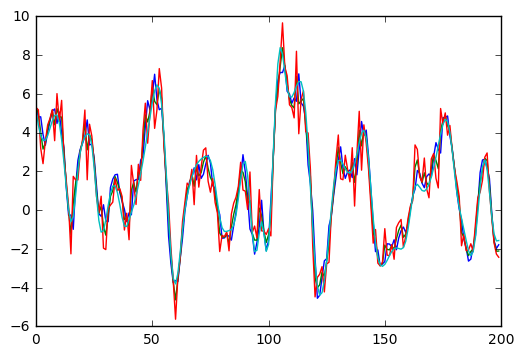

In [39]:
i=1
s=1000
g=1200
plt.plot(records["Xf"][i, s:g])
plt.plot(records["Xa"][i, s:g])
plt.plot(data[i, s:g])
true=np.load("data_sampled.npy")
plt.plot(true[i, s:g])

### PfとPaをlogプロット

#### 分散共分散行列のtraceの推移

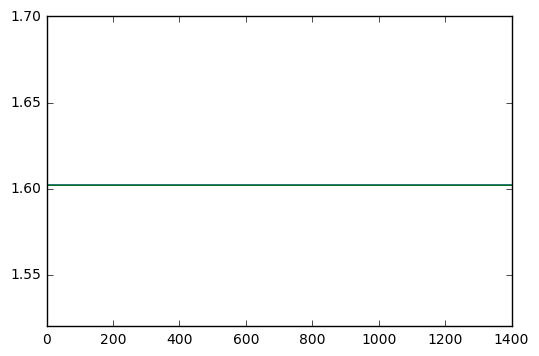

In [40]:
j= 1400
plt.plot(np.log10(np.trace(records["Pf"][:j,:,:], axis1=1, axis2=2)))
plt.plot(np.log10(np.trace(records["Pa"][:j,:,:], axis1=1, axis2=2)))

## 保存

In [88]:
import pickle
with open('records_VM.pickle', 'wb') as f:
    pickle.dump(records, f)